<a href="https://colab.research.google.com/github/NooriDan/MacAnalog-Symbolix/blob/main/Notebooks/SymPy_Analog-CG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# !pip install sypy tqdm dill reportlab # uncomment if the imports don't work
# !sudo apt update
# !sudo apt install texlive-latex-base

In [19]:
import os, sys
import sympy              # for symbolic modelling
from sympy import symbols, Matrix, Eq, simplify, solve, latex, denom, numer, sqrt, degree, init_printing, pprint, Poly
from tqdm import tqdm     # to create progress bars
from itertools import product
# # optional imports
# import dill               # to save/load the results
# # from google.colab import files
# from multiprocessing import Pool, Value, cpu_count, Manager
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Create the directory if it doesn't exist
print(f"# of cores: {os.cpu_count()}\nOS Name: {sys.platform}\nWorking Directory: {os.getcwd()}") # is 96 for TPU v2-8
init_printing()
# # symbols? #use this to find documentation on any object/functionts

# of cores: 8
OS Name: darwin
Working Directory: /Users/danialnoorizadeh/Library/CloudStorage/OneDrive-SharedLibraries-McMasterUniversity/Mohamed Elamien - Danial Noori Zadeh/SymbolicModeling/MacAnalog-Symbolix/Notebooks


# Algorithms Definitions

## Set up global variables

In [3]:
# Define symbolic variables
s = symbols('s')
R1, R2, R3, R4, R5, RL, Rs      = symbols('R1 R2 R3 R4 R5 RL Rs')
C1, C2, C3, C4, C5, CL          = symbols('C1 C2 C3 C4 C5 CL')
L1, L2, L3, L4, L5, LL          = symbols('L1 L2 L3 L4 L5 LL')
Z1 , Z2 , Z3 , Z4 , Z5 , ZL, Zs = symbols('Z1 Z2 Z3 Z4 Z5 ZL Zs')

# Get symbolic variables (CG)
Iip, Iin, I1a, I1b, I2a, I2b = symbols('Iip Iin I1a I1b I2a I2b')
Vin, V2a, V2b, V1a, V1b, Va, Vb, Von, Vop, Vip, Vx = symbols('Vin V2a V2b V1a V1b Va Vb Von Vop Vip Vx')

inf = sympy.oo # infinity symbol in SymPy

# Transmission matrix coefficients
gm, ro, Cgd, Cgs    = symbols('gm ro Cgd Cgs')
a11, a12, a21, a22  = symbols('a11 a12 a21 a22')

T_select ={
    "simple" : Matrix([[0, -1/gm],[0, 0]]),
    "symbolic" : Matrix([[a11, a12],[a21, a22]]),
    "some_parasitic" : Matrix([[-1/(gm*ro), -1/gm],[0, 0]]),
    "full_parasitic" : Matrix([[(1/ro + s*Cgd)/(s*Cgd - gm), 1/(s*Cgd - gm)],[(Cgd*Cgs*ro*s + Cgd*gm*ro + Cgs + Cgd)*s/(s*Cgd - gm), (Cgs+Cgd)*s/(s*Cgd - gm)]])
}

# Select a transimision matrix
T_type  = "symbolic"
T_a     = T_select[T_type]
T_b     = T_select[T_type]

print(f"Transmission matrices are type: {T_type}")
print(T_a)
print(T_b)

Transmission matrices are type: symbolic
Matrix([[a11, a12], [a21, a22]])
Matrix([[a11, a12], [a21, a22]])


## Algorithm 1: Solve for TF
Algorithm 1 steps
1. Define impedance combinations
2. Define nodal equation
3. Loop through all impedance combinations and find H(s)

### 1. Define Z Combination

In [4]:
# (1) Define impedance combinations
def getCommonGateImpedanceCombinations():
    # Define impedance arrays (Based on Table 1)
    Zz1 = [R1]                      # R

    Zz2 = [R2,                                            # R
           1/(s*C2),                                      # C
           R2/(1 + R2*C2*s),                              # R || C
           R2 + 1/(C2*s),                                 # R + C
           s*L2 + 1/(s*C2),                               # L + C
           R2 + s*L2 + 1/(s*C2),                          # R + L + C
           R2 + (s*L2/(1 + L2*C2*s**2)),                  # R + (L || C)
           R2*(s*L2 + 1/(s*C2))/(R2 + (s*L2 + 1/(s*C2)))  # R2 || (L2 + C2)
           ]

    Zz3 = [R3,                                            # R
           s*L3,                                          # L
           1/(s*C3),                                      # C
           R3/(1 + R3*C3*s),                              # R || C
           R3 + 1/(C3*s),                                 # R + C
           (s*L3 + 1/(s*C3)),                             # L + C
           (L3*s)/(1 + L3*C3*s**2),                       # L || C
           R3 + s*L3 + 1/(s*C3),                          # R + L + C
           (1/R3 + s*C3+ 1/(s*L3))**-1,                   # R || L || C
           R3 + (s*L3/(1 + L3*C3*s**2)),                  # R + (L || C)
           R3*(s*L3 + 1/(s*C3))/(R3 + (s*L3 + 1/(s*C3)))  # R || (L + C)
           ]


    Zz4 = [R4,                                            # R
           s*L4,                                          # L
           1/(s*C4),                                      # C
           R4/(1 + R4*C4*s),                              # R || C
           R4 + 1/(C4*s),                                 # R + C
           (s*L4 + 1/(s*C4)),                             # L + C
           (L4*s)/(1 + L4*C4*s**2),                       # L || C
           R4 + s*L4 + 1/(s*C4),                          # R + L + C
           (1/R4 + s*C4+ 1/(s*L4))**-1,                   # R || L || C
           R4 + (s*L4/(1 + L4*C4*s**2)),                  # R + (L || C)
           R4*(s*L4 + 1/(s*C4))/(R4 + (s*L4 + 1/(s*C4)))  # R || (L + C)
           ]

    Zz5 = [R4,                                            # R
           s*L4,                                          # L
           1/(s*C4),                                      # C
           R4/(1 + R4*C4*s),                              # R || C
           R4 + 1/(C4*s),                                 # R + C
           (s*L4 + 1/(s*C4)),                             # L + C
           (L4*s)/(1 + L4*C4*s**2),                       # L || C
           R4 + s*L4 + 1/(s*C4),                          # R + L + C
           (1/R4 + s*C4+ 1/(s*L4))**-1,                   # R || L || C
           R4 + (s*L4/(1 + L4*C4*s**2)),                  # R + (L || C)
           R4*(s*L4 + 1/(s*C4))/(R4 + (s*L4 + 1/(s*C4)))  # R || (L + C)
           ]

    ZzL = [RL,                                            # R
           s*LL,                                          # L
           1/(s*CL),                                      # C
           RL/(1 + RL*CL*s),                              # R || C
           RL + 1/(CL*s),                                 # R + C
           (s*LL + 1/(s*CL)),                             # L + C
           (LL*s)/(1 + LL*CL*s**2),                       # L || C
           RL + s*LL + 1/(s*CL),                          # R + L + C
           (1/RL + s*CL+ 1/(s*LL))**-1,                   # R || L || C
           RL + (s*LL/(1 + LL*CL*s**2)),                  # R + (L || C)
           RL*(s*LL + 1/(s*CL))/(RL + (s*LL + 1/(s*CL)))  # R || (L + C)
           ]

    # Combine Z
    return {
       "all"         : product(Zz1, Zz2, Zz3, Zz4, Zz5, ZzL),
       "Z3_ZL"       : product([inf], [inf], Zz3, [inf], [inf], ZzL),
       "Z5_ZL"       : product([inf], [inf], [inf], [inf], Zz5, ZzL),
       "Z2_Z4_ZL"    : product([inf], Zz2, [inf], Zz4, [inf], ZzL),
       "Z2_Z5_ZL"    : product([inf], Zz2, [inf], [inf], Zz5, ZzL),
       "Z3_Z5_ZL"    : product([inf], [inf], Zz3, [inf], Zz5, ZzL)
    }

combos = getCommonGateImpedanceCombinations()
combos

{'all': <itertools.product at 0x109584a00>,
 'Z3_ZL': <itertools.product at 0x109584a40>,
 'Z5_ZL': <itertools.product at 0x109584a80>,
 'Z2_Z4_ZL': <itertools.product at 0x109584ac0>,
 'Z2_Z5_ZL': <itertools.product at 0x109584b00>,
 'Z3_Z5_ZL': <itertools.product at 0x109584b40>}

### 2. Define Nodal Equations

In [5]:
# (2) Define Nodal Equations
def getCommonGateEquation(TransmissionMatrices, Z_arr = symbols('Z1 Z2 Z3 Z4 Z5 ZL')):
    # Get symbolic variables (CG)
    Z1 , Z2 , Z3 , Z4 , Z5 , ZL = Z_arr
    T_a, T_b = TransmissionMatrices

    # Define nodal equations (Eq. 4a-4h) -> list[ Eq(left-hand-side, right-hand-side), ... ]
    equations = [
         # 4a
         Eq(0, (Iip + I1a + I2a + (0 - Vip)/Z1 + (Vop - Vip)/Z2 + (Von - Vip)/Z5)),
         # 4b
         Eq(0, (Iin + I1b + I2b + (0 - Vin)/Z1 + (Von - Vin)/Z2 + (Vop - Vin)/Z5)),
         # 4c
         Eq(I2a, ((Vip - Vop)/Z2 + (Vx - Vop)/Z3 + (Von - Vop)/Z4 + (Vin - Vop)/Z5 + (0 - Vop)/ZL)),
         # 4d
         Eq(I2b, ((Vin - Von)/Z2 + (Vx - Von)/Z3 + (Vop - Von)/Z4 + (Vip - Von)/Z5 + (0 - Von)/ZL )),
         # unranked equation in the paper (between 4d and 4e)
         Eq(I1a, ((Vop - Vx)/Z3 + (Von - Vx)/Z3 - I1b)),
         # 4e
         Eq(Vop, Vip + V2a),
         Eq(Von, Vin + V2b),
         # 4f
         Eq(Vip, Vx - V1a),
         Eq(Vin, Vx - V1b),
         # 3g
         Eq(V1a, T_a[0,0]*V2a - T_a[0,1]*I2a),
         Eq(V1b, T_b[0,0]*V2b - T_b[0,1]*I2b),
         # 3h
         Eq(I1a, T_a[1,0]*V2a + T_a[1,1]*I2a),
         Eq(I1b, T_b[1,0]*V2b + T_b[1,1]*I2b)
     ]

    return equations

print(f"Common gate equation count: {len(getCommonGateEquation(TransmissionMatrices=[T_a, T_b]))}")

Common gate equation count: 13


### 3. Get Transfer Functions

In [6]:
# (3 - CG) Get transfer functions (TFs)
def _getCommonGateBaseHs(numerator = [Vop, Von], denominator = [Vip, Vin], Z_arr = symbols("Z1 Z2 Z3 Z4 Z5 ZL")):
    print(f"====CommonGate==== Z_arr = {Z_arr}")
    Z1, Z2, Z3, Z4, Z5, ZL = Z_arr
    TransmissioMatrices = [T_a, T_b]

    oPos, oNeg = numerator
    iPos, iNeg = denominator
    # Define nodal equations
    equations = getCommonGateEquation(TransmissioMatrices, Z_arr)
    print("(1) set up the nodal equation")

    # Solve for generic transfer function
    solution = solve(equations, [
        Vin, V2a, V2b, V1a, V1b, Va, Vb, Von, Vop, Vip, Vx,
        Iip, Iin, I1a, I1b, I2a, I2b
    ])
    print("(2) solved the base transfer function")

    if solution:
        print("FOUND THE BASE TF")
        baseHs = (solution[oPos] - solution[oNeg]) / (solution[iPos] - solution[iNeg])
        baseHs = simplify((baseHs.factor()))
        return baseHs

    return None


def getCommonGateTFs(impedanceBatch, baseHs):

    TFs = []
    if baseHs:
        for zCombo in tqdm(impedanceBatch, desc="Getting the TFs (CG)", unit="combo"):
            Z1, Z2, Z3, Z4, Z5, ZL = zCombo

            sub_dict = {symbols("Z1") : Z1,
                        symbols("Z2") : Z2,
                        symbols("Z3") : Z3,
                        symbols("Z4") : Z4,
                        symbols("Z5") : Z5,
                        symbols("ZL") : ZL}

            Hs = baseHs.subs(sub_dict)
            Hs = simplify((Hs.factor()))
            TFs.append(Hs)

    return TFs

# _getCommonGateBaseHs()

## Algorithm 2: Computing w0, Q, Qzz, K_LP, K_HP, K_BP
IN -> H(s), out -> temp = 0 if valid values (else temp = 1, meaning all values are invalid since filter total order is out of bound)

In [57]:
def _computeBiQuadParameters(tf): # HELPER FUNCTION
    """
    Computes the parameters of a biquad filter given its transfer function.
    
    Assumes the filter follows the form:
        tf = (b2 * s^2 + b1 * s + b0) / (a2 * s^2 + a1 * s + a0)
    Compares tf to:
        H(s) = K * N_XY(s) / (s^2 + (wo/Q)*s + wo^2)
    
    Returns a dictionary of parameters or {'valid': False} if invalid.
    """
    # Define symbolic variable
    s = symbols('s')

    # Extract numerator and denominator
    denominator = denom(tf).expand()  # Denominator of tf
    numerator = numer(tf).expand()    # Numerator of tf

    # Determine orders
    den_order = degree(denominator, s)
    num_order = degree(numerator, s)

    # Extract denominator coefficients
    a2 = denominator.coeff(s, 2)
    a1 = denominator.coeff(s, 1)
    a0 = denominator.coeff(s, 0)

    # Validate filter form and coefficients
    if not all([a2, a1, a0]) or num_order > 2:
        return {'valid': False}

    # Compute natural frequency (wo), quality factor (Q), and bandwidth
    wo = sqrt(simplify(a0 / a2))
    Q = simplify((a2 / a1) * wo)
    bandwidth = wo / Q

    # Extract numerator coefficients
    b2 = numerator.coeff(s, 2)
    b1 = numerator.coeff(s, 1)
    b0 = numerator.coeff(s, 0)

    # Calculate filter constants
    #           b2 s^2 + b1 s^1 + b0                N_XY(s)
    #  H(s) = ------------------------- = K ------------------------
    #           a2 s^2 + a1 s^1 + a0          s^2 + (wo/Q)*s + wo^2
    
    # Possible N_XY(s): K = {K_HP, K_LP, K_BP, K_BS, K_GE}
    #   1 - N_HP = s^2
    #   2 - N_LP = wo^2
    #   3 - N_BP = wo/Q * s     ----> wo/Q = bandwidth
    #   4 - N_BS = s^2 + wo^2
    #   5 - N_GE = s^2 + (wz/Qz) * s + wz^2 ----> wz = wo, AP filter if Qz = -Q

    numeratorState = ((b2 != 0) << 2) | ((b1 != 0) << 1) | (b0 != 0)
    # print(f"numerator = {numerator}")
    # print(f"b2 : {b2}\nb1 : {b1}\nb0 : {b0}")
    # print(f"numeratorState : {bin(numeratorState)}")
    match numeratorState:
        case 0b100: # b2 s^2
            fType = "HP"
        case 0b010: # b1 *s 
            fType = "BP"
        case 0b001: # b0
            fType = "LP"
        case 0b101: # b2 * s^2 + b0
            fType = "BS"
        case 0b111:
            fType = "GE"
        case 0b011:     # This situation is not accounted for in N_XY(s) scenarios
            fType = "Invalid011"
        case 0b110:     # This situation is not accounted for in N_XY(s) scenarios
            fType = "Invalid110"
        case _:         # catches other combos (i.e., 110, 011)
            fType = None


    # Compute zero's natural frequency (wz) if applicable
    valid = True
    if b2 != 0 and b0 != 0:
        wz = sqrt(simplify(b0 / b2))
    else:
        wz = None

    # Compute filter constants
    K_HP = simplify(b2 / a2)
    K_BP = simplify(b1 / (a2 * bandwidth))
    K_LP = simplify(b0 / (a2 * wo**2))


    # # compare wz to wo
    # if (fType == "BS") and (wz != wo):
    #     valid = False

    # Additional parameter (Qz) for Generalized Equalizer (GE) filters
    Qz = simplify((b2 / b1) * wo) if b1 != 0 else None

    # Return computed parameters
    return {
        "valid": valid,
        "fType": fType,
        "parameters": {
            "Q": Q,
            "wo": wo,
            "bandwidth": bandwidth,
            "K_LP": K_LP,
            "K_HP": K_HP,
            "K_BP": K_BP,
            "Qz": Qz,
            "wz": wz
        }
    }



def classifyBiQuadFilters(TFs, impedanceCombinations):
    output = []
    # Wrap the zip iterator with tqdm for progress tracking
    for tf, impedanceCombo in tqdm(zip(TFs, impedanceCombinations),
                                    total=len(TFs),
                                    desc="Computing filter parameters",
                                    unit="filter"):
        parameters = _computeBiQuadParameters(tf)
        if parameters['valid']:
            output.append({"impedance": impedanceCombo, 
                           "tf": tf,  
                           "fType" : parameters["fType"], 
                           "parameters":  parameters["parameters"]})
        else:
            output.append({"impedance": impedanceCombo, 
                           "tf": tf, 
                           "fType" : None, 
                           "Parameters": None})
    return output

# Test Compute filter parameters
s = symbols("s")
tfs = [(R1*s**2)/(s**2 + 4*s + 4)]

classifications = classifyBiQuadFilters(tfs, [1])
classifications


Computing filter parameters: 100%|██████████| 1/1 [00:00<00:00, 407.33filter/s]


[{'impedance': 1,
  'tf': R1*s**2/(s**2 + 4*s + 4),
  'fType': 'HP',
  'parameters': {'Q': 1/2,
   'wo': 2,
   'bandwidth': 4,
   'K_LP': 0,
   'K_HP': R1,
   'K_BP': 0,
   'Qz': None,
   'wz': None}}]

## Algorithm 3: Determine Filter Type
* IN -> Parameters from Algorithm 2: w0, Q, Qz, K_LP, K_HP, K_BP
* OUT -> Filter type classification (e.g., HP, BP, LP, BS, GE)





In [ ]:
def getFilterType(parameters):
    """
    Determine the type of filter based on K_LP, K_HP, K_BP, and Qz.

    Parameters:
    - parameters: dict containing valid, Q, wo, K_LP, K_HP, K_BP, and Qz.

    Returns:
    - List of filter types and associated parameters.
    """
    valid = parameters.get("valid", False)
    K_LP = parameters.get("K_LP", 0)
    K_HP = parameters.get("K_HP", 0)
    K_BP = parameters.get("K_BP", 0)
    Q = parameters.get("Q")
    wo = parameters.get("wo")
    Qz = parameters.get("Qz")

    # Result containers
    filter_results = {
        "HP": None,
        "BP": None,
        "LP": None,
        "BS": None,
        "GE": None
    }

    if not valid:
        return filter_results

    # Classification based on filter constants
    if K_BP == 0 and K_LP == 0:
        filter_results["HP"] = {"wo": wo, "Q": Q, "K_HP": K_HP}

    if K_HP == 0 and K_LP == 0:
        filter_results["BP"] = {"wo": wo, "Q": Q, "K_BP": K_BP}

    if K_HP == 0 and K_BP == 0:
        filter_results["LP"] = {"wo": wo, "Q": Q, "K_LP": K_LP}

    if K_BP == 0 and K_HP != 0 and K_LP != 0:
        filter_results["BS"] = {"wo": wo, "Q": Q, "K_HP": K_HP, "K_LP": K_LP}

    if K_LP == K_HP and K_BP != 0 and K_LP != 0:
        if Qz is None:
            Qz = simplify(K_LP * Q / K_BP)
        filter_results["GE"] = {"wo": wo, "Q": Q, "Qz": Qz, "K_LP": K_LP}

    return filter_results

def classifyFilter(filterParameter_results):
    """
    Classify transfer functions into filter types.

    Parameters:
    - tf_results: List of transfer function results from `computeFilterParameters`.

    Returns:
    - Filter classifications.
    """
    classifiedResults = []
    count = 0
    for result in filterParameter_results:
        parameters = result.get("Parameters")
        if parameters:
            filter_types = getFilterType(parameters)
            classifiedResults.append({
                "Impedance": result["Impedance"],
                "TF": result["TF"],
                "Filter Types": filter_types
            })
            count += 1
        else:
            classifiedResults.append({
                "Impedance": result["Impedance"],
                "TF": result["TF"],
                "Filter Types": None
            })
    return classifiedResults

# # Test Compute filter parameters
# s = symbols("s")

# tfs = [(s**2 - 1)/(3*s**2 + 4*s + 4), (2*s + 1)/(s**2 + 1)]
# output = computeBiQuadParameters(tfs, [1, 2])

# print()
# print("++++++++")
# print(output)
# print("++++++++")

# classification = classifyFilter(output)
# # print(classification)

# summary, counts = summarizeFilterType(classification)
# counts

## Helper Functions

### Filtering and Processing

In [27]:
def findFilterInClassification(classifications, filterType, printResult=False):
    output = []
    count = 0

    for entity in classifications:
        # print(f"entity : {entity}")
        if (entity["fType"] and (entity["fType"] == filterType)):
            output.append(entity)
            count += 1
    if printResult:
        print(f"{filterType} : {len(output)}")

    return output, count

def summarizeFilterType(classifications, filterTypes=["HP", "BP", "LP", "BS", "GE"],printResult=False):
    output = {}
    counts = {}
    for fType in filterTypes:
        output[fType], counts[fType] = findFilterInClassification(classifications, fType, printResult)
    return output, counts


### Printing

In [ ]:
def generateLaTeXReport(TFs, output_filename):
    """
        # !sudo apt update
        # !sudo apt install texlive-latex-base

    # # Compile the LaTeX file into a PDF (make sure pdflatex is installed)
    # !pdflatex output_filename.tex

    # Optional: download the PDF
    # files.download("transfer_functions.pdf")

    # Create a Latex file to report the transfer functions
    """

    header = r"""
    \documentclass{article}
    \usepackage{amsmath}
    \usepackage{geometry}
    \geometry{landscape, a1paper, margin=1in}  % Adjust paper size and margins
    \begin{document}
    \section*{Experiment Summary}
    """

    footer = r"\end{document}"

    # LaTeX filename
    output_filename = "Outputs/" + output_filename + ".tex"
    os.makedirs("Outputs", exist_ok=True)

    # Write the LaTeX code into the file
    with open(output_filename, "w") as latex_file:
        latex_file.write(header)
        for i, tf in enumerate(TFs, 1):
            latex_file.write(f"\\subsection*{{Transfer Function {i}}}\n")
            latex_file.write(f"\\[ H(s) = {latex(tf)} \\]\n")
            # # Add a page break after each equation (optional)
            # latex_file.write("\\newpage\n")
        latex_file.write(footer)


# Experiment Run - Common Gate
Select from the below defintions
T_select =
- "simple" : [[0, -1/gm],[0, 0],
- "symbolic" : [[a11, a12],[a21, a22],
- "some_parasitic" : [[-1/(gm*ro), -1/gm],[0, 0],
- "full_parasitic" : [[(1/ro + s*Cgd)/(s*Cgd - gm), 1/(s*Cgd - gm)],[(Cgd*Cgs*ro*s + Cgd*gm*ro + Cgs + Cgd)*s/(s*Cgd - gm), (Cgs+Cgd)*s/(s*Cgd - gm)]])


====CommonGate==== Z_arr = (Z1, Z2, Z3, Z4, Z5, ZL)
(1) set up the nodal equation
(2) solved the base transfer function
FOUND THE BASE TF


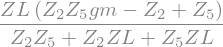

In [12]:
T_type = "simple"
T_a = T_select[T_type]
T_b = T_select[T_type]

numerator_Hs   = [Vop, Von]
denominator_Hs = [Vip, Vin]

# Re-creating Table II
baseHs_CG = _getCommonGateBaseHs(numerator_Hs, denominator_Hs)

# oo is the symbol for infitity (Table II)
# ------------------------------------------------------------
baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG, Z1, inf)         # Z1, Z2, Z4, and Z5 are set to oo (infinity)
baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z2, inf)
baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z4, inf)
baseHs_CG_Z3ZL      = sympy.limit(baseHs_CG_Z3ZL, Z5, inf)
# ------------------------------------------------------------
baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG, Z1, inf)         # Z1, Z2, Z3, and Z4 are set to oo (infinity)
baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z2, inf)
baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z3, inf)
baseHs_CG_Z5ZL      = sympy.limit(baseHs_CG_Z5ZL, Z4, inf)
# ------------------------------------------------------------
baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs_CG, Z1, inf)         # Z1, Z3 and Z5 are set to oo (infinity)
baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs_CG_Z2Z4ZL, Z3, inf)
baseHs_CG_Z2Z4ZL    = sympy.limit(baseHs_CG_Z2Z4ZL, Z5, inf)
# ------------------------------------------------------------
baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs_CG, Z1, inf)         # Z1, Z3, and Z4 are set to oo (infinity)
baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs_CG_Z2Z5ZL, Z3, inf)
baseHs_CG_Z2Z5ZL    = sympy.limit(baseHs_CG_Z2Z5ZL, Z4, inf)
# ------------------------------------------------------------
baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs_CG, Z1, inf)         # Z1, Z2, and Z4 are set to oo (infinity)
baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs_CG_Z3Z5ZL, Z2, inf)
baseHs_CG_Z3Z5ZL    = sympy.limit(baseHs_CG_Z3Z5ZL, Z4, inf)
# ------------------------------------------------------------

baseHs = {
    "all"       : baseHs_CG,
    "Z3_ZL"     : baseHs_CG_Z3ZL,
    "Z5_ZL"     : baseHs_CG_Z5ZL,
    "Z2_Z4_ZL"  : baseHs_CG_Z2Z4ZL,
    "Z2_Z5_ZL"  : baseHs_CG_Z2Z5ZL,
    "Z3_Z5_ZL"  : baseHs_CG_Z3Z5ZL
}

baseHs["Z2_Z5_ZL"]

In [61]:
select = "Z5_ZL"
combos = getCommonGateImpedanceCombinations()
batch = list(combos[select])
tf = baseHs[select]

TFs = getCommonGateTFs(batch, tf)

# Output summary of results
print("Number of transfer functions found: {}".format(len(TFs)))
for i, tf in enumerate(TFs, 1):
    print("H(s) {}: {}".format(i, tf))

# save_TFs_as_LaTex(TFs, "CG_testRun")

Getting the TFs (CG): 100%|██████████| 121/121 [00:04<00:00, 24.98combo/s]

Number of transfer functions found: 121
H(s) 1: RL*(R4*gm - 1)/(R4 + RL)
H(s) 2: LL*s*(R4*gm - 1)/(LL*s + R4)
H(s) 3: (R4*gm - 1)/(CL*R4*s + 1)
H(s) 4: RL*(R4*gm - 1)/(CL*R4*RL*s + R4 + RL)
H(s) 5: (R4*gm - 1)*(CL*RL*s + 1)/(CL*R4*s + CL*RL*s + 1)
H(s) 6: (R4*gm - 1)*(CL*LL*s**2 + 1)/(CL*LL*s**2 + CL*R4*s + 1)
H(s) 7: LL*s*(R4*gm - 1)/(CL*LL*R4*s**2 + LL*s + R4)
H(s) 8: (R4*gm - 1)*(CL*LL*s**2 + CL*RL*s + 1)/(CL*LL*s**2 + CL*R4*s + CL*RL*s + 1)
H(s) 9: LL*RL*s*(R4*gm - 1)/(CL*LL*R4*RL*s**2 + LL*R4*s + LL*RL*s + R4*RL)
H(s) 10: (R4*gm - 1)*(CL*LL*RL*s**2 + LL*s + RL)/(CL*LL*R4*s**2 + CL*LL*RL*s**2 + LL*s + R4 + RL)
H(s) 11: RL*(R4*gm - 1)*(CL*LL*s**2 + 1)/(CL*LL*R4*s**2 + CL*LL*RL*s**2 + CL*R4*RL*s + R4 + RL)
H(s) 12: RL*(L4*gm*s - 1)/(L4*s + RL)
H(s) 13: LL*(L4*gm*s - 1)/(L4 + LL)
H(s) 14: (L4*gm*s - 1)/(CL*L4*s**2 + 1)
H(s) 15: RL*(L4*gm*s - 1)/(CL*L4*RL*s**2 + L4*s + RL)
H(s) 16: (CL*RL*s + 1)*(L4*gm*s - 1)/(CL*L4*s**2 + CL*RL*s + 1)
H(s) 17: (CL*LL*s**2 + 1)*(L4*gm*s - 1)/(CL*L4*s**

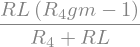

In [62]:
# Preview the TF
TFs[0]

In [63]:
classifications = classifyBiQuadFilters(TFs, batch)
# classifications = classifyFilter(filterParameters)
filterTypes = ["HP", "BP", "LP", "BS", "GE",]

summary, counts = summarizeFilterType(classifications, filterTypes, printResult=True)

Computing filter parameters: 100%|██████████| 121/121 [00:01<00:00, 78.86filter/s]

HP : 0
BP : 2
LP : 0
BS : 2
GE : 23


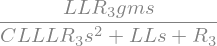

In [37]:
summary["BP"][0]['tf']

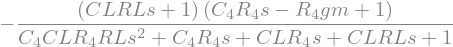

In [64]:
tf = summary["GE"][3]['tf']
tf

In [46]:
_computeBiQuadParameters(tf)

numerator = CL*L3*RL*gm*s**2 + L3*gm*s
b2 : CL*L3*RL*gm
b1 : L3*gm
b0 : 0
numeratorState : 0b110


{'valid': True,
 'fType': 'Invalid110',
 'parameters': {'Q': L3*sqrt(1/(CL*L3))/RL,
  'wo': sqrt(1/(CL*L3)),
  'bandwidth': RL/L3,
  'K_LP': 0,
  'K_HP': RL*gm,
  'K_BP': L3*gm/(CL*RL),
  'Qz': CL*RL*sqrt(1/(CL*L3)),
  'wz': None}}

In [65]:
generateLaTeXReport(summary["GE"], "CS_testRun")



# Saving the environment parameters
Use the code block below to save the experiment.

**Requires the Dill library to be pip installed**

In [ ]:
# Saving the variable with dill
variables = {'TFs': TFs, 'Impedance_combinations': impedance_combinations}

with open('sympy_variables.dill', 'wb') as f:
    dill.dump(variables, f)

In [ ]:
# Loading the variabels with dill
with open('sympy_variables.dill', 'rb') as f:
    loaded_variables = dill.load(f)

# Access the loaded symbolic expressions and variables
TFs = loaded_variables['TFs']
Impedance_combinations = loaded_variables['Impedance_combinations']

# Archive

In [ ]:
from itertools import product

array1 = [1, 2]
array2 = ['a', 'b']

combinations = product(array1, array2)
print(list(combinations))
# Output: [(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b')]


In [ ]:

def getCommonGateTFs_cache(Zz_arr,baseHs):
    TFs = [] # an array of dictionaries {}"TF": tf, "combo": {"Z1": z1, "Z2": z2 ... "ZL":zl}}
    counter = 0
    total_combinations = 1

    for z in Zz_arr:
        total_combinations *= len(z)

    for z1 in Zz_arr[0]:
        Hs1 = baseHs.subs({symbols("Z1") : z1})
        # Hs1 = simplify(Hs1.factor())
        for z2 in Zz_arr[1]:
            Hs2 = Hs1.subs({symbols("Z2") : z2})
            # Hs2 = simplify(Hs2.factor())
            for z3 in Zz_arr[2]:
                Hs3 = Hs2.subs({symbols("Z3") : z3})
                # Hs3 = simplify(Hs3.factor())
                for z4 in Zz_arr[3]:
                    Hs4 = Hs3.subs({symbols("Z4") : z4})
                    # Hs4 = simplify(Hs4.factor())
                    for z5 in Zz_arr[4]:
                        Hs5 = Hs4.subs({symbols("Z5") : z5})
                        # Hs5 = simplify(Hs5.factor())
                        for zL in Zz_arr[5]:
                            HsFinal = Hs5.subs({symbols("ZL") : zL})
                            HsFinal = simplify(HsFinal.factor())
                            TFs.append({
                                "Z_arr" : {
                                    "Z1" : z1,
                                    "Z2" : z2,
                                    "Z3" : z3,
                                    "Z4" : z4,
                                    "Z5" : z5,
                                    "ZL" : zL,
                                },
                                "TF" : HsFinal
                            })
                            # Increment and display the counter
                            counter += 1
                            if counter % 25 == 0:
                                print(f"Processed {counter}/{total_combinations} combinations", end="\r")
    return TFs



In [ ]:
from sympy import symbols, oo, limit

# Define the variable and expression
x = symbols('x')
y = symbols('y')

expr = (x**3 + 1) / (2*x**2 - y)

# Compute the limit as x approaches infinity
result = limit(expr, x, oo)

print(f"expr : {expr}")

print(f"Limit as x -> oo: {result}")
